In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

# Backpropagation

In this practical you will implement the backpropagation algorithm and apply it for following classification network for classifying three classes:
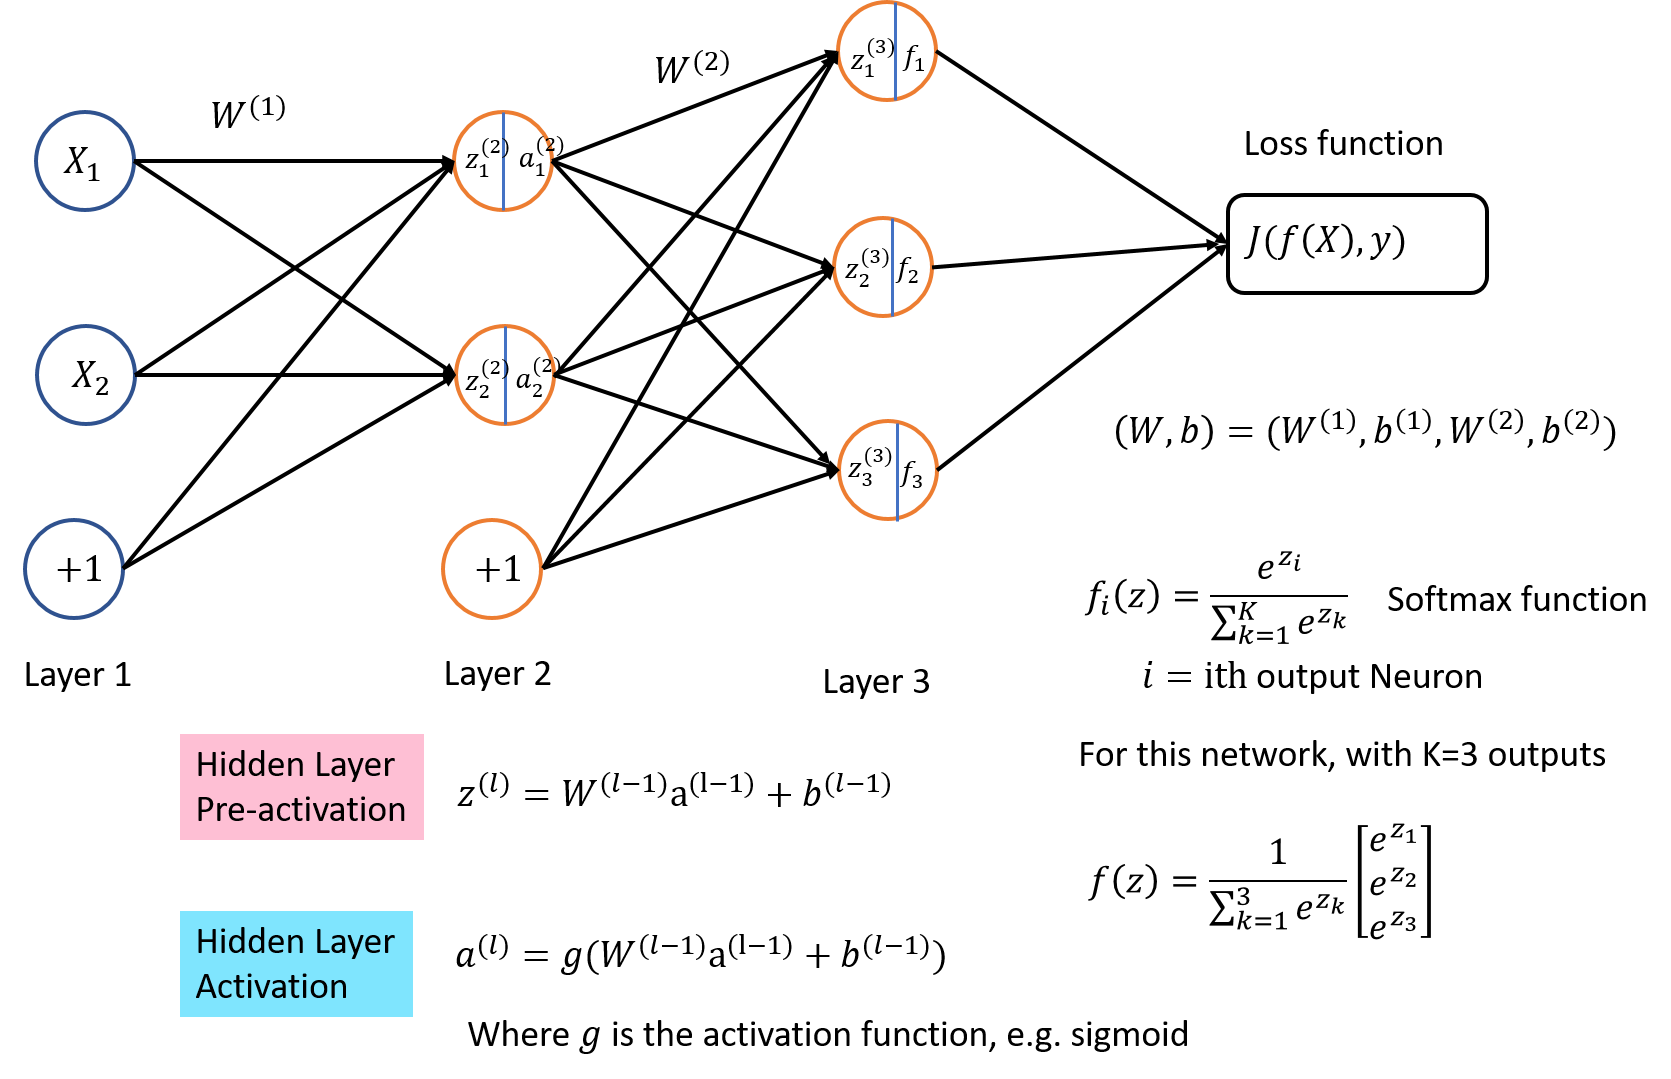

In [2]:
x = tf.constant([[0.1], [0.8]])
y = tf.constant([[0.0], [0.0],[1.0]])
W1 = tf.constant([[0.2, 0.5], [0.3, 0.4]])
W2 = tf.constant([[0.1, 0.3], [0.7, 0.4], [0.01, 0.02]])
bias1 = tf.constant([[0.1], [0.6]])
bias2 = tf.constant([[0.2], [0.1], [0.4]])

1. Implement a function for the forward propagation on a hidden layer $l$ that returns the logits. (5 Pts)






In [3]:
def preActivation(X,weights,bias):
 return tf.matmul(weights, X) + bias

def forward_propagation(last_hidden_layer_inputs):
    outputDistribution = tf.nn.softmax(last_hidden_layer_inputs, axis=0)
    return outputDistribution

2. Implement a function for the activation on a hidden layer with the sigmoid function (5 Pts)


In [4]:
def sigmoid_activation(Z):
  A = tf.nn.sigmoid(Z)
  return A

def sigmoid_derivation(input):
  return sigmoid_activation(input) * (1.0 - sigmoid_activation(input));

3. Implement a function for the delta rule on the output layer 
> $\delta^{L}=(\mathbf y-z^L)\odot (-\mathbf 1)$ (10 Pts)



In [5]:
def delta_rule_output(y,z):
  return (y-z)*(-1.0)

4. Implement a function for the delta rule on a hidden layer $l$ (10 Pts)
> $\delta^{l}=\left( \left(W^{(l)}\right)^T\delta^{l+1}\right)\odot g'(z^{(l)})$


In [6]:
def delta_rule_hidden_layer(W,z,delta_next_layer):
    return tf.matmul(tf.transpose(W), delta_next_layer) * sigmoid_derivation(z)

5. Implement a function for computing the gradient for the weigths $W^{(l)}$ (10 Pts)



In [7]:
def weight_gradient(delta_next_layer, postactivation):
  return (tf.matmul(delta_next_layer,tf.transpose(postactivation)));

6. Implement a function for computing the gradient for the biases $b^{(l)}$ (5 Pts)
> $\nabla_{W^{(l)}}J=\delta^{(l+1)}\left(a^{(l)}\right)^T$, 
> $\nabla_{b^{(l)}}J=\delta^{(l+1)}$


In [8]:
def bias_gradient(delta_next_layer):
  return delta_next_layer

7. Put everything together to apply it for the given network with inputs $x= \begin{bmatrix} 0.1\\ 0.8 \end{bmatrix}$, initial values for $W^{(1)}=\begin{bmatrix} 0.2 & 0.5 \\0.3 & 0.4 \end{bmatrix}$ and $b^{(1)} =\begin{bmatrix}0.1\\0.6 \end{bmatrix}$, $W^{(2)}=\begin{bmatrix} 0.1 & 0.3 \\ 0.7 & 0.4 \\ 0.01 & 0.02 \end{bmatrix}$ and $b^{(2)} =\begin{bmatrix} 0.2\\0.1\\0.4\end{bmatrix}$, the correct class of the input being the third one.


> a. assemble your network given in the figure and perform a forward propagation (15 Pts)


>  b.  use the functions defined beforehand to implement the backpropagation for so many iterations that your crossentropy loss is ≈ 0.4 (40 Pts)

In [12]:
alpha = 0.1
iterations = 0
cce = 100.0

while cce > 0.4:
  #forward propagation 
  z2 = preActivation(x, W1, bias1)
  a2 = sigmoid_activation(z2);

  z3 = preActivation(a2, W2, bias2);
  a3 = forward_propagation(z3);

  # backpropagation
  deltaOutputLayer = delta_rule_output(y, a3)
  deltaLayer2 = delta_rule_hidden_layer(W2,z2,deltaOutputLayer)
  deltaWeights2 = weight_gradient(deltaOutputLayer,a2)
  deltaBias2 = bias_gradient(deltaOutputLayer)
  deltaWeights1 = weight_gradient(deltaLayer2,x)
  deltaBias1 = bias_gradient(deltaLayer2)

  # updating weights and biases with delta
  W2 = W2 - (alpha * deltaWeights2)
  bias2 = bias2 - (alpha * deltaBias2)
  W1 = W1 - (alpha * deltaWeights1)
  bias1 = bias1 - (alpha * deltaBias1)

  # calculate crossentropy
  loss = tf.keras.losses.CategoricalCrossentropy()
  cce = loss(np.transpose(y), np.transpose(a3))
  iterations += 1
  print(cce.numpy())
  print(iterations)

print("final cce", cce)
print("final iteration count", iterations)

0.34520444
1
final cce tf.Tensor(0.34520444, shape=(), dtype=float32)
final iteration count 1


# Verification
For a sanity check after the **first** iteration:

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(2,)))
model.add(tf.keras.layers.Dense(2, activation='sigmoid',kernel_initializer=tf.keras.initializers.Constant(np.transpose(W1)),
    bias_initializer=tf.keras.initializers.Constant(np.transpose(bias1))))
model.add(tf.keras.layers.Dense(3, activation='softmax',kernel_initializer=tf.keras.initializers.Constant(np.transpose(W2)),
    bias_initializer=tf.keras.initializers.Constant(np.transpose(bias2))))



with tf.GradientTape() as tape:
  # Forward pass
  tape.watch(tf.constant(x))
  f_output = model(np.transpose(x))
  loss = tf.keras.losses.CategoricalCrossentropy()
  cce = loss(np.transpose(y),f_output)
  tape.watch(cce)
# Calculate gradients with respect to every trainable variable
grad = tape.gradient(cce, model.trainable_variables)
for var, g in zip(model.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')
print(grad)
print("loss ",cce.numpy())

dense_2/kernel:0, shape: (2, 2)
dense_2/bias:0, shape: (2,)
dense_3/kernel:0, shape: (2, 3)
dense_3/bias:0, shape: (3,)
[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.00121238, -0.00207637],
       [-0.00969902, -0.01661099]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.01212378, -0.02076374], dtype=float32)>, <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 0.08190871,  0.09854452, -0.18045321],
       [ 0.09543851,  0.11482225, -0.21026073]], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.1325061 ,  0.15941834, -0.29192442], dtype=float32)>]
loss  0.34520447
